# Projecto de Machine Learning-Francisco Quintero

# RESIGNATION PREDICTION

## 1-Cargamos librerías y módulos a utilizar

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import plotly as py
import plotly.graph_objs as go
import os

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler,SMOTE
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot, plot
from sklearn.tree import plot_tree

warnings.filterwarnings("ignore")




init_notebook_mode(connected=True)


## 2-Cargamos y limpiamos datos

In [2]:
df_HR=pd.read_csv('./Employee.csv') #Cargamos datos

In [3]:
#Eliminamos columnas que no son relevantes o sesgarian el modelo
df_HR=df_HR.drop(['Gender','JoiningYear'],axis=1)

In [4]:
#Renombramos los valores de 'City' para ponernos en contexto local.
df_HR['City']=df_HR['City'].replace(['New Delhi','Bangalore','Pune'],['Madrid','Barcelona','Valencia'])

# 3-EDA Análisis Exploratorio de los datos

## 3.1-General

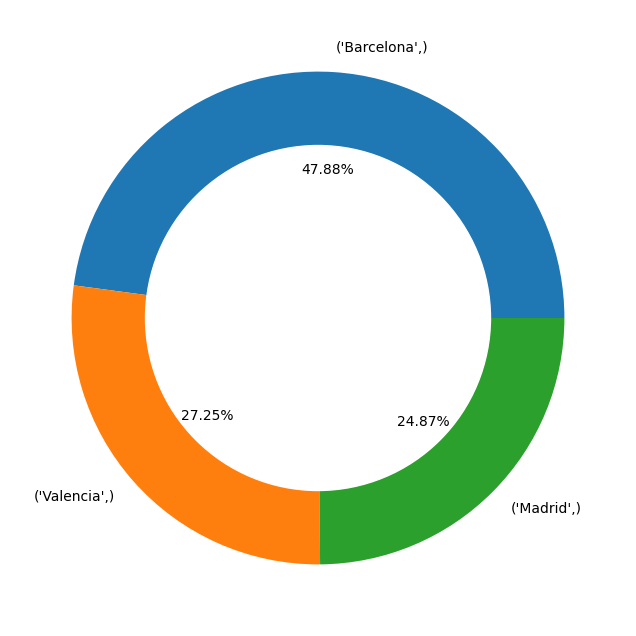

In [5]:
#Vemos la distribucion total de los registros por ciudad

# create data
data = df_HR[["City"]].value_counts().sort_values(ascending=False)
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')

plt.figure(figsize=(8,8))
plt.pie(data.values,
        labels=data.index,
        autopct='%1.2f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#Observamos que Barcelona tiene la mayor cantidad de contrataciones.

<Figure size 3000x1000 with 0 Axes>

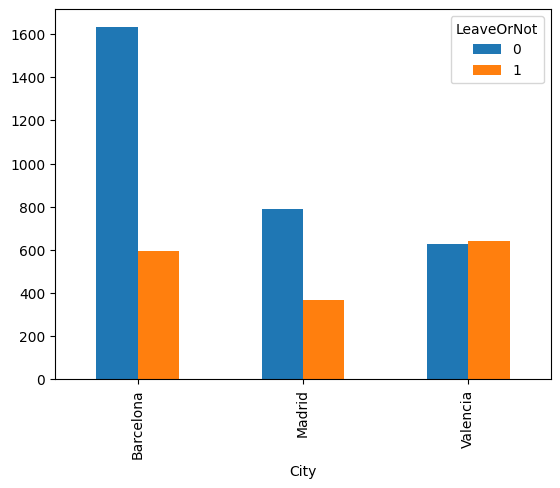

In [6]:
plt.figure(figsize=(30,10));
df_plot = df_HR.groupby(['City', 'LeaveOrNot']).size().reset_index().pivot(columns='LeaveOrNot', index='City', values=0)
df_plot.plot(kind='bar', stacked=False);


#sns.catplot(x="City",col="LeaveOrNot",col_wrap=2,data=df_HR,kind="count");

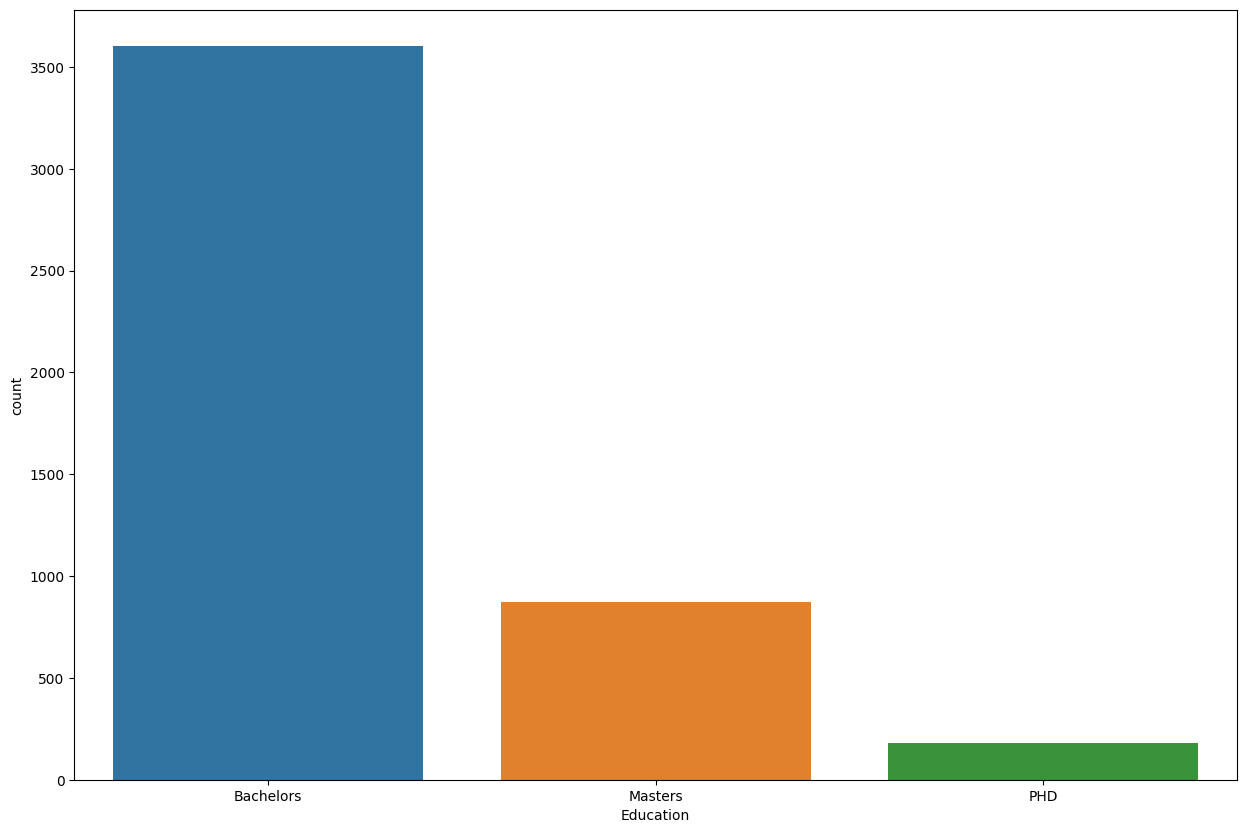

In [7]:
#Verificamos Nivel de educacion
plt.figure(figsize=(15,10))
sns.countplot(x="Education", data=df_HR);

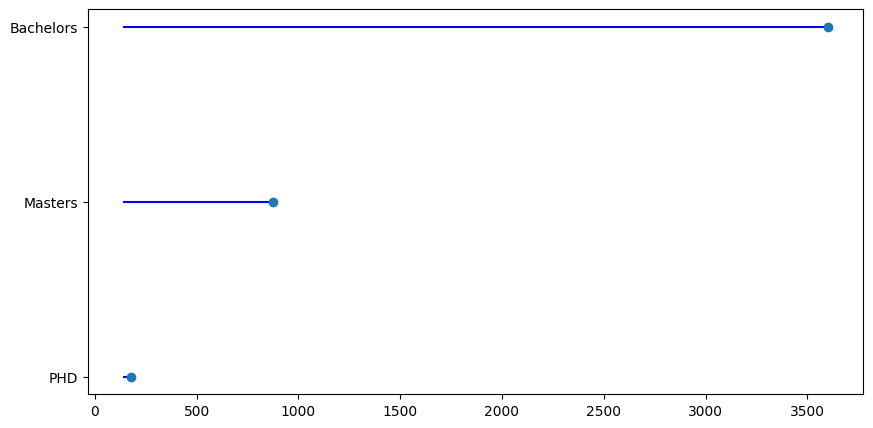

In [8]:
conteo = df_HR['Education'].value_counts(ascending=True)

plt.figure(figsize=(10,5))
plt.hlines(y=conteo.index,
           xmin=140,
           xmax=conteo,
           color='blue')
plt.plot(conteo, conteo.index, "o");

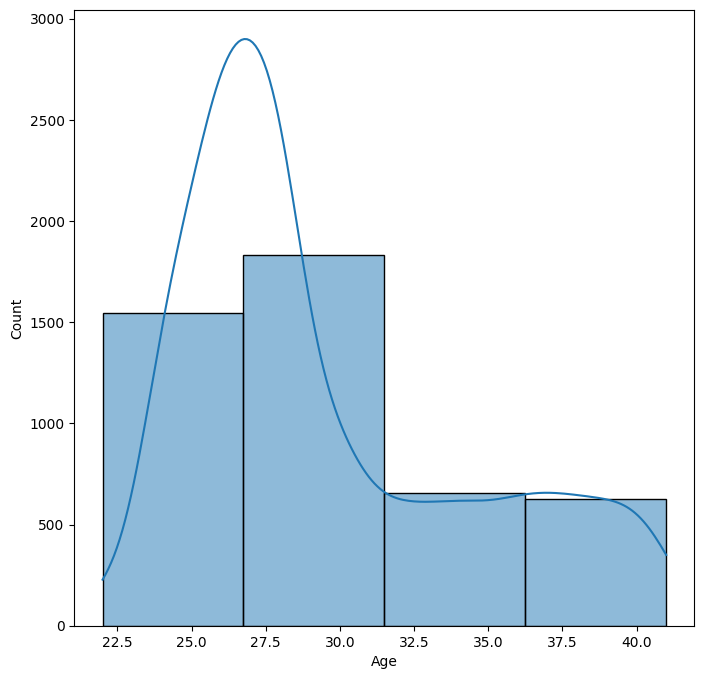

In [9]:
#Densidad de probabilidad respecto a la edad de contratación promedio

df_HR['Age'].value_counts

plt.figure(figsize=(8,8))
sns.histplot(df_HR["Age"], kde=True, bins =4);

#La edad de contratación media es de 29 años

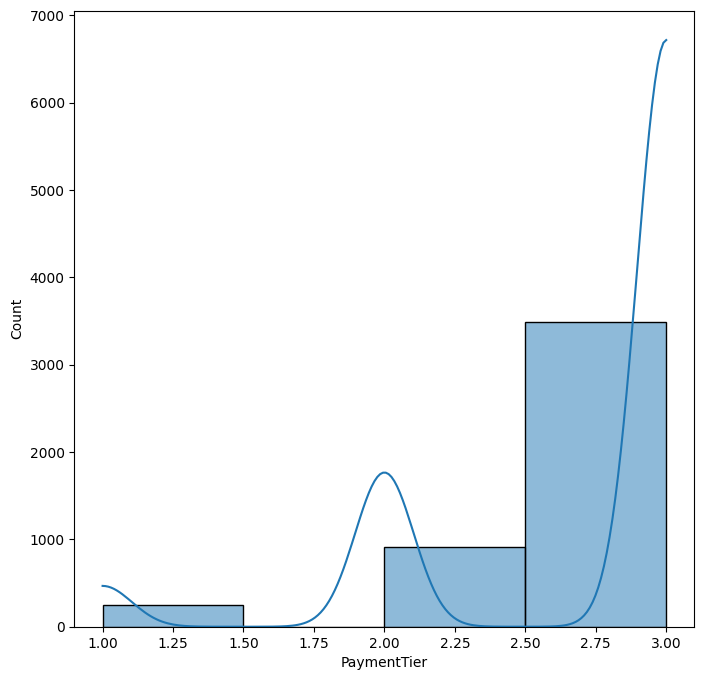

In [10]:
#Densidad de probabilidad respecto a la edad de contratación promedio

df_HR['PaymentTier'].value_counts

plt.figure(figsize=(8,8))
sns.histplot(df_HR["PaymentTier"], kde=True, bins =4);

#La edad de contratación media es de 29 años

In [11]:
df_HR.PaymentTier.mean()

2.6982591876208897

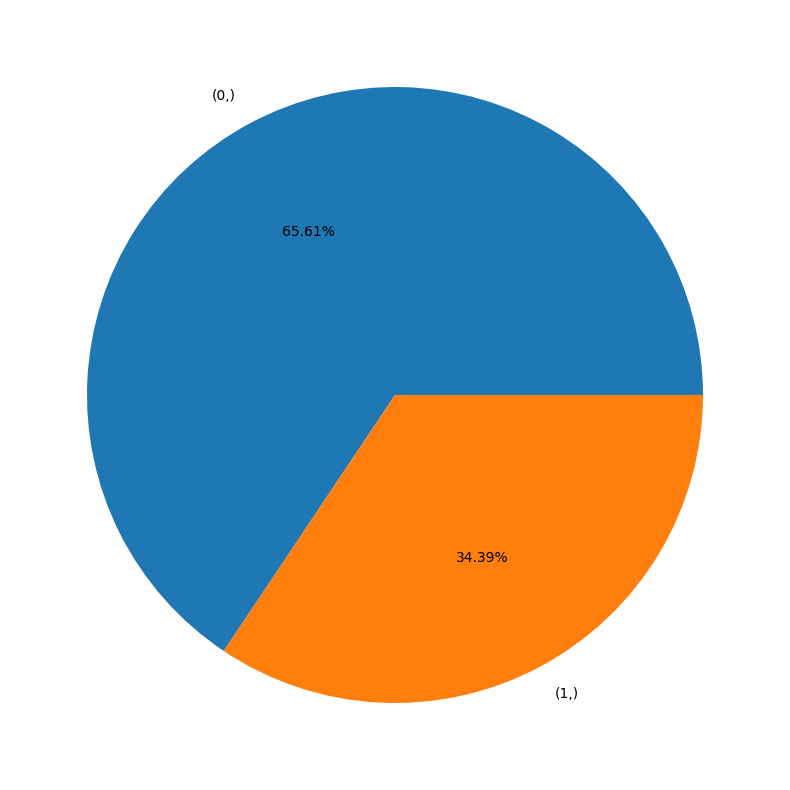

In [12]:
# create data
data = df_HR[['LeaveOrNot']].value_counts()
 
# Create a circle for the center of the plot


plt.figure(figsize=(10,10))
plt.pie(data.values,
        labels=data.index,
        autopct='%1.2f%%')
p=plt.gcf()

plt.show()

# 4-Preparando los datos

In [13]:
'''Verificamos correlación entre las variables
para identificar aquellas que tengan multicolinealidad'''

df_HR.corr()


,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
PaymentTier,1.000000,0.007631,0.018314,-0.197638
Age,0.007631,1.000000,-0.134643,-0.051126
ExperienceInCurrentDomain,0.018314,-0.134643,1.000000,-0.030504
LeaveOrNot,-0.197638,-0.051126,-0.030504,1.000000


In [14]:
df_HR.describe() #Entender que tan dispersos están los valores de las variables numéricas

,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000
mean,2.698259,29.393295,2.905652,0.343864
std,0.561435,4.826087,1.558240,0.475047
min,1.000000,22.000000,0.000000,0.000000
25%,3.000000,26.000000,2.000000,0.000000
50%,3.000000,28.000000,3.000000,0.000000
75%,3.000000,32.000000,4.000000,1.000000
max,3.000000,41.000000,7.000000,1.000000


In [15]:
'''Verificamos cuantos datos únicos tienen las variables categóricas
así determinar qué tipo de codificación utilizar para tratarlas'''

print(df_HR.Education.unique())
print(df_HR.City.unique())
print(df_HR.EverBenched.unique())

['Bachelors' 'Masters' 'PHD']
['Barcelona' 'Valencia' 'Madrid']
['No' 'Yes']


## 4.1-Dividimos en Train y Test

In [16]:

X=df_HR.drop(['LeaveOrNot'],axis=1)
y=df_HR['LeaveOrNot']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3257, 6)
(3257,)
(1396, 6)
(1396,)


## 4.2-Tratamos variables categóricas

In [17]:
# Aplicamos un get_dummies ya que son pocas las categoricas, asi que no aumentaria el numero de columnas drasticamente

X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test,drop_first=True)

print(len(X_train.columns))
print(len(X_test.columns))

# Verificamos que las columnas son las mismas para Train y Test

8
8


In [18]:
#Homologamos el Dtype del Dataset

for col in X_train.columns[X_train.dtypes == "uint8"]:
    X_train[col] = X_train[col].astype("int64")

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3257 entries, 2005 to 860
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   PaymentTier                3257 non-null   int64
 1   Age                        3257 non-null   int64
 2   ExperienceInCurrentDomain  3257 non-null   int64
 3   Education_Masters          3257 non-null   int64
 4   Education_PHD              3257 non-null   int64
 5   City_Madrid                3257 non-null   int64
 6   City_Valencia              3257 non-null   int64
 7   EverBenched_Yes            3257 non-null   int64
dtypes: int64(8)
memory usage: 229.0 KB


## 4.3-Balanceamos los datos de Train

In [19]:
#Verificamos que tan balanceado estan las muestras

'''Notamos que el target esta desbalanceado para entrenarlo,
asi que procedemos a balancear, creando nuevos registros que favorezcan ese balance'''

df_HR.LeaveOrNot.value_counts()

#Pero primero

0    3053
1    1600
Name: LeaveOrNot, dtype: int64

In [20]:
#Importamos ROS y SMOTE para balancear el dataset
oversample = RandomOverSampler(sampling_strategy='minority')
smote=SMOTE()

In [21]:
#Procedemos a Balancear el Train para no sesgar el proceso de aprendizaje de nuestro algoritmo

X_train,y_train=smote.fit_resample(X_train,y_train)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4266, 8)
(4266,)
(1396, 8)
(1396,)


In [22]:
#Ahora tenemos el target balanceado

y_train.value_counts()

1    2133
0    2133
Name: LeaveOrNot, dtype: int64

# 5-Machine Learning

## 5.1-Eligiendo el Modelo

### 5.1.1-Definimos modelos e Hiper parámetros de cada uno

In [23]:
#Probaremos 3 modelos

#Regresion Logistica
#Vector Soporte Clasificador
#Random Forest Clasificador

reg_log = Pipeline(steps = [
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("reglog", LogisticRegression())])

svc = Pipeline([
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("svc", svm.SVC())])

rand_forest_param = {
    'n_estimators': [10,100,500],
    'max_features': [2,3]
}

rand_forest = RandomForestClassifier()

re_log_param = {
    "imputer__strategy": ['mean', 'median', 'most_frequent'],
    "reglog__penalty": ["l1", "l2"],
    "reglog__C": np.arange(0.1, 4, 0.5)
}

svc_param = {
    "selectkbest__k": [1,2,3],
    "svc__C": np.arange(0.1, 0.9, 0.1),
    "svc__kernel": ['linear', 'poly', 'rbf']
}

### 5.1.2-Definimos GSCV e Hiper parámetros de cada uno de los modelos

In [24]:
#Aplicamos el GSCV para cada uno de los modelos, con diferentes hiper-parametros

gs_reg_log = GridSearchCV(reg_log,
re_log_param,
cv=10,
scoring = 'accuracy',
n_jobs = -1,
verbose = 1)

gs_svm = GridSearchCV(svc,
svc_param,
cv=10,
scoring = 'accuracy',
n_jobs = -1,
verbose = 1)

gs_rand_forest = GridSearchCV(rand_forest,
rand_forest_param,
cv=10,
scoring = 'accuracy',
n_jobs = -1,
verbose = 1)

grids = {
    "gs_reg_log": gs_reg_log,
    "gs_svm": gs_svm,
    "gs_rand_forest": gs_rand_forest}

## 5.2-Ejecutamos la busqueda de el mejor modelo

In [25]:
%%time 
for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

#Ejecutamos los GSCV con los datos seleccionados para entrenar, y medimos el tiempo de ejecución.

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Fitting 10 folds for each of 72 candidates, totalling 720 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Wall time: 45.4 s


In [26]:
#Creamos un DataFrame con el GSCV que mejor lo hizo, para ayudar con la visualizacion

best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns = ["Grid", "Best score"])
best_grids.sort_values(by = "Best score", ascending = False)

#Nuestro modelo es un Random Forest Clasificador

,Grid,Best score
2,gs_rand_forest,0.684731
1,gs_svm,0.667600
0,gs_reg_log,0.631958


In [27]:
# Vemos cual es el mejor modelo o estimador, los mejores parámetros y su score.

print("Best estimator:", gs_rand_forest.best_estimator_)
print("Best params:", gs_rand_forest.best_params_)
print("Best score:", gs_rand_forest.best_score_)

Best estimator: RandomForestClassifier(max_features=2)
Best params: {'max_features': 2, 'n_estimators': 100}
Best score: 0.6847313388527888


## 5.3-Hora depredecir

### 5.3.1 Predicción con Test

In [28]:
#Verificamos como lo hace en Test

mejor_estimador = gs_rand_forest.best_estimator_
mejor_estimador.score(X_test, y_test)

0.6991404011461319

In [29]:
fe_i=mejor_estimador.feature_importances_
df=pd.DataFrame(fe_i,index=X_train.columns).sort_values(0,ascending=False)*100
df=df.rename(columns={0:'Variables_importantes'})
df

,Variables_importantes
Age,34.107376
PaymentTier,21.437737
ExperienceInCurrentDomain,15.341356
Education_Masters,11.631765
City_Valencia,7.805990
City_Madrid,5.140800
EverBenched_Yes,2.603151
Education_PHD,1.931825


### 5.3.1-Predicción con X_nueva

In [30]:
X_nueva = np.array([[1,33,0,1,0,1,1,0]])

In [31]:
predict=mejor_estimador.predict(X_nueva)

if predict[0] == 1:
    print('Es muy probable que el candidato presente su renuncia al termino de 2 años')
else:
    print('El candidato es óptimo para la posición')


El candidato es óptimo para la posición


In [32]:
X_nueva_1 = np.array([[2,18,0,0,1,0,0,1]])

In [33]:
predict=mejor_estimador.predict(X_nueva_1)

if predict[0] == 1:
    print('Es muy probable que el candidato presente su renuncia al termino de 2 años')
else:
    print('El candidato es óptimo para la posición')

Es muy probable que el candidato presente su renuncia al termino de 2 años


# Gracias!